In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Parameter
import torch.nn.functional as F
import pandas as pd
import numpy as np
import math

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler

In [101]:
num_nodes = 10

train_rate = 0.5
seq_len = 20
output_dim = pred_len = 10
batch_size = 1 #32
lr = 0.001
training_epoch = 1001
validation_rate = 0.1
l2_coeff = 0.0001


#for ILI Region data
adj_pearson = pd.read_csv('input_data/Region_adj_geo1.csv', header=None)
adj = np.mat(adj_pearson)

#region features(data)
data = pd.read_csv('input_data/ILI_region_feature_1997-2020.csv')
data = np.mat(data, dtype=np.float32)

scaler = MinMaxScaler()
scaler.fit(data[0:int(len(data)/2)])   #절반까지(train data)에 대해서만 fit
data = scaler.transform(data)

print(data[-5:])


[[1.82012    3.1085544  1.6115223  0.6289664  0.4157108  0.7908482
  0.28640518 0.37363324 0.31908202 2.917647  ]
 [1.3491006  1.869935   1.2565175  0.44287363 0.33733055 0.5245536
  0.18484686 0.25835678 0.23137377 2.1294117 ]
 [1.254497   1.1125563  1.0218861  0.33155304 0.28832117 0.38214287
  0.13272434 0.17213371 0.18170387 1.4282353 ]
 [0.8554297  0.6910956  0.96202123 0.2925961  0.287626   0.3502232
  0.13057497 0.16526085 0.1615844  1.435294  ]
 [0.68820786 0.48724365 0.8052784  0.2448424  0.2716371  0.28191966
  0.1144546  0.12527335 0.14806664 1.2917646 ]]


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device, torch.cuda.get_device_name()

(device(type='cuda', index=0), 'NVIDIA GeForce GTX 1070 Ti')

In [5]:
time_len =data.shape[0]     #총 시간
num_nodes = data.shape[1]   #지역 node 갯수
print(time_len, num_nodes)

NameError: name 'data' is not defined

In [104]:
def preprocess_data(data, time_len, train_rate, validation_rate, seq_len, pred_len):
    """
    하나의 node에 대해서 seq_len=20 짜리의 데이터를 취한 것을, 
    모든 node=10 에 대해서 쌓아서, 
    하나의 time_step에 대한 data를 만들고,
    모든 time_step에 대해서 쌓은 크기
    의 data를 floattensor로 반환하는 함수
    """
    train_size = int(time_len * train_rate)
    validation_size = int(time_len * validation_rate)
    print(f"train_size : {train_size}, validation_size : {validation_size}")
    train_data = data[0:train_size]
    print(f"train_data shape : {train_data.shape}")
    validation_data = data[train_size - seq_len : train_size + validation_size] #train data 바로 다음 시점부터 validation 시작
    test_data = data[train_size + validation_size - seq_len : time_len]
    print(f"test_data shape : {test_data.shape}")
    
    X_train, y_train, X_test, y_test = [], [], [], []
    
    for i in range(len(train_data) - seq_len - pred_len):
        
        temp = train_data[i:i + seq_len + pred_len]
        
        X_train.append(np.transpose(temp[:seq_len]))    #여기선 transpose인데
        y_train.append(temp[seq_len + pred_len - 1])    #여기선 왜 단일 값? -> 
        
    for i in range(len(test_data) - seq_len - pred_len):
        
        temp = test_data[i:i + seq_len + pred_len]
        
        X_test.append(np.transpose(temp[:seq_len]))
        y_test.append(temp[seq_len + pred_len - 1])
        
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    print(f"\nX_train : {X_train.shape} | y_train : {y_train.shape} \nX_test : {X_test.shape} | y_test : {y_test.shape}")
    
    return torch.FloatTensor(X_train).to(device), torch.FloatTensor(y_train).to(device), torch.FloatTensor(X_test).to(device), torch.FloatTensor(y_test).to(device)

In [105]:
X_train, y_train, X_test, y_test = preprocess_data(data, time_len, train_rate, validation_rate, seq_len, pred_len)
#print(X_train.dtype, y_train.dtype)


train_size : 589, validation_size : 117
train_data shape : (589, 10)
test_data shape : (493, 10)

X_train : (559, 10, 20) | y_train : (559, 10) 
X_test : (463, 10, 20) | y_test : (463, 10)


In [106]:
training_data_count = len(X_train)
print(training_data_count, X_train.shape)

559 torch.Size([559, 10, 20])


In [107]:
train = torch.utils.data.TensorDataset(X_train, y_train)
test = torch.utils.data.TensorDataset(X_test, y_test)

trainloader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [108]:
rnn_hidden_size = 12    #for dim check 12
rnn_num_layers = 1

adj = torch.from_numpy(np.array(adj_pearson))
adj = adj.float().to(device)
adj = F.normalize(adj, p=2, dim=1, eps=1e-12, out=None)

In [109]:
#model 앞부분에 node별로 temporal dependency를 추출하기 위한 RNN

class cola_gnn(nn.Module):
    
    def __init__(self, input_size, sequence_length, rnn_num_layers, adj_mat = adj_pearson, rnn_hidden_size=12, conv_channel_num=1, attn_coeff_h_size=10, device=device):
        super().__init__()
        self.device = device            #cuda else cpu
        self.input_size = input_size    #10(node)*20(seq_length) tensor
        self.rnn_hidden_size = rnn_hidden_size
        self.sequence_length = sequence_length  #seq_length
        self.rnn_num_layers = rnn_num_layers    #
        self.conv_channel_num = conv_channel_num
        self.attn_coeff_h_size = attn_coeff_h_size
        self.adj = torch.from_numpy(np.array(adj_mat))
        self.adj = self.adj.float().to(device)
        self.adj = F.normalize(adj, p=2, dim=1, eps=1e-6, out=None)
        
        
        self.RNN_modules = {
            'RNN_0' : nn.RNN(input_size = self.sequence_length, hidden_size = self.rnn_hidden_size, num_layers = self.rnn_num_layers, batch_first = True, nonlinearity = 'tanh', device=self.device),
            'RNN_1' : nn.RNN(input_size = self.sequence_length, hidden_size = self.rnn_hidden_size, num_layers = self.rnn_num_layers, batch_first = True, nonlinearity = 'tanh', device=self.device),
            'RNN_2' : nn.RNN(input_size = self.sequence_length, hidden_size = self.rnn_hidden_size, num_layers = self.rnn_num_layers, batch_first = True, nonlinearity = 'tanh', device=self.device),
            'RNN_3' : nn.RNN(input_size = self.sequence_length, hidden_size = self.rnn_hidden_size, num_layers = self.rnn_num_layers, batch_first = True, nonlinearity = 'tanh', device=self.device),
            'RNN_4' : nn.RNN(input_size = self.sequence_length, hidden_size = self.rnn_hidden_size, num_layers = self.rnn_num_layers, batch_first = True, nonlinearity = 'tanh', device=self.device),
            'RNN_5' : nn.RNN(input_size = self.sequence_length, hidden_size = self.rnn_hidden_size, num_layers = self.rnn_num_layers, batch_first = True, nonlinearity = 'tanh', device=self.device),
            'RNN_6' : nn.RNN(input_size = self.sequence_length, hidden_size = self.rnn_hidden_size, num_layers = self.rnn_num_layers, batch_first = True, nonlinearity = 'tanh', device=self.device),
            'RNN_7' : nn.RNN(input_size = self.sequence_length, hidden_size = self.rnn_hidden_size, num_layers = self.rnn_num_layers, batch_first = True, nonlinearity = 'tanh', device=self.device),
            'RNN_8' : nn.RNN(input_size = self.sequence_length, hidden_size = self.rnn_hidden_size, num_layers = self.rnn_num_layers, batch_first = True, nonlinearity = 'tanh', device=self.device),
            'RNN_9' : nn.RNN(input_size = self.sequence_length, hidden_size = self.rnn_hidden_size, num_layers = self.rnn_num_layers, batch_first = True, nonlinearity = 'tanh', device=self.device)  
        }
        
        self.Dil_Conv_short_modules = {
            'Dil_Conv_0' : nn.Conv1d(1, self.conv_channel_num, self.sequence_length, device=self.device),
            'Dil_Conv_1' : nn.Conv1d(1, self.conv_channel_num, self.sequence_length, device=self.device),
            'Dil_Conv_2' : nn.Conv1d(1, self.conv_channel_num, self.sequence_length, device=self.device),
            'Dil_Conv_3' : nn.Conv1d(1, self.conv_channel_num, self.sequence_length, device=self.device),
            'Dil_Conv_4' : nn.Conv1d(1, self.conv_channel_num, self.sequence_length, device=self.device),
            'Dil_Conv_5' : nn.Conv1d(1, self.conv_channel_num, self.sequence_length, device=self.device),
            'Dil_Conv_6' : nn.Conv1d(1, self.conv_channel_num, self.sequence_length, device=self.device),
            'Dil_Conv_7' : nn.Conv1d(1, self.conv_channel_num, self.sequence_length, device=self.device),
            'Dil_Conv_8' : nn.Conv1d(1, self.conv_channel_num, self.sequence_length, device=self.device),
            'Dil_Conv_9' : nn.Conv1d(1, self.conv_channel_num, self.sequence_length, device=self.device)
        }
        
        self.Dil_Conv_long_modules = {
            'Dil_Conv_0' : nn.Conv1d(1, self.conv_channel_num, int(self.sequence_length/2), dilation=2, device=self.device),    #출력이 8*2?
            'Dil_Conv_1' : nn.Conv1d(1, self.conv_channel_num, int(self.sequence_length/2), dilation=2, device=self.device),
            'Dil_Conv_2' : nn.Conv1d(1, self.conv_channel_num, int(self.sequence_length/2), dilation=2, device=self.device),
            'Dil_Conv_3' : nn.Conv1d(1, self.conv_channel_num, int(self.sequence_length/2), dilation=2, device=self.device),
            'Dil_Conv_4' : nn.Conv1d(1, self.conv_channel_num, int(self.sequence_length/2), dilation=2, device=self.device),
            'Dil_Conv_5' : nn.Conv1d(1, self.conv_channel_num, int(self.sequence_length/2), dilation=2, device=self.device),
            'Dil_Conv_6' : nn.Conv1d(1, self.conv_channel_num, int(self.sequence_length/2), dilation=2, device=self.device),
            'Dil_Conv_7' : nn.Conv1d(1, self.conv_channel_num, int(self.sequence_length/2), dilation=2, device=self.device),
            'Dil_Conv_8' : nn.Conv1d(1, self.conv_channel_num, int(self.sequence_length/2), dilation=2, device=self.device),
            'Dil_Conv_9' : nn.Conv1d(1, self.conv_channel_num, int(self.sequence_length/2), dilation=2, device=self.device)
        }

        #여기서는 RNN hidden state를 그대로 사용할 것 이기 때문에 마지막 sequential layer가 필요 없음
        
        #defining parameters for general attention coeff.
        
        self.Gen_Attn_Weights = {
            'W_s' : Parameter(torch.Tensor(self.attn_coeff_h_size, self.rnn_hidden_size)).to(device),
            'W_t' : Parameter(torch.Tensor(self.attn_coeff_h_size, self.rnn_hidden_size)).to(device),
            'v_t' : Parameter(torch.Tensor(self.attn_coeff_h_size)).to(device),
            'b_s' : Parameter(torch.Tensor(self.attn_coeff_h_size)).to(device),
            'b_v' : Parameter(torch.Tensor(1)).to(device)
            #activation Fn ELU applied in forward
        }
        
        self.Element_wise_M = {
            'W_m' : Parameter(torch.Tensor(self.input_size[0], self.input_size[0])).to(device),
            'b_m' : Parameter(torch.Tensor(1)).to(device)
        }
        
        self.Graph_Mes_Pass = {
            'W_g' : Parameter(torch.Tensor(4, 3)).to(device),   #expand hidden size
            'b_g' : Parameter(torch.Tensor(4)).to(device)
        }
        
        self.Output_layer = nn.Linear(in_features=16, out_features=1, bias=True).to(device)        #RNN hidden size(12) + Graph Mes Pass output size(4)
        
        self.init_weights()
     
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data) # best
                #nn.init.kaiming_normal_(p.data)

            else:
                stdv = 1. / math.sqrt(p.size(0)+1e-6)
                p.data.uniform_(-stdv, stdv)

        
        #RNN 선언하고
        #~Dilated Conv 선언하고
        #Loc-Aware-Attn Matrix 만들고
        #graph message passing 하고
        #output layer 제작하고
        #backprop은 나중에 최적화
        
    def forward(self, x):
        '''
        ***WRONG DESCRIPTION***
        h_RNN_0 = torch.zeros(self.rnn_num_layers, x.size()[0], self.rnn_hidden_size).to(self.device)      #나중에 node 별로 모델 새로 선언 필요
        #initial hidden state 여기서는 zeros, 나중에는 normalized values 시도 | x.size()[0] == batch_size, rnn_hidden_size 정해줘야함
        _, h_RNN_0 = self.rnn(x, h_RNN_0)       #***우리는 여기서 hidden_state가 필요함! 나중에 모든 node에 대해서 hidden_state들을 쌓아야됨***
        #문제는, 여기서의 output값이 필요한지는 확실치 않음 - 이 RNN으로 값을 예측하려는 것이 아니기 때문, 아마 hidden 만 쓸 것으로 생각
        '''
        
        
        #여기에 batch 에 따른 iter 필요???
        for batch in range(len(x)):

            single_batch = x[batch]            #batch 하나 가져오기
            
            
            RNN_hidden_concat = torch.zeros(self.input_size[0], self.rnn_hidden_size).to(self.device)   #10(num_node)*12(num_hidden)
            Conv_hidden_concat = torch.zeros(self.input_size[0], self.conv_channel_num, 3).to(self.device)  #10 * 1 * 3(short_output_len + long_output_len)
            Attn_coeff_Mat = torch.zeros(self.input_size[0], self.input_size[0]).to(self.device)    #10*10
            #Loc_aware_attn_Mat = torch.zeros(self.input_size[0], self.input_size[0]).to(self.device)    #10*10
            # Graph_mess_Mat = torch.zeros(self.input_size[0], 4).to(self.device)         #Dil_Conv short + long output = 3 -> expanded hidden size to 4
            result = torch.zeros(self.input_size[0]).to(self.device)    #10
            # if batch == 0:
            #     print(f"Making RNN, Dil_Conv modules for {batch}...")

            #Making RNN, Dil_Conv modules
            for i in range(self.input_size[0]):  #node 갯수 만큼

                single_seq = single_batch[i]
                single_seq = single_seq.reshape([1, 1, self.sequence_length])   #batch 1개 * node 1개 * seq_len
                
                #RNN part
                rnn_out_i, _ = self.RNN_modules[f'RNN_{i}'](single_seq)       #RNNs training, activation needed
                RNN_hidden_concat[i] = rnn_out_i       #for future loc-aware-attn? 이렇게 저장하면 안될듯, 나중에 RNN 호출하는걸로
            
                #Dilated Conv part
                conv_out_short_i = self.Dil_Conv_short_modules[f'Dil_Conv_{i}'](single_seq)
                conv_out_long_i = self.Dil_Conv_long_modules[f'Dil_Conv_{i}'](single_seq)
                Conv_hidden_concat[i, :, :conv_out_short_i.size()[2]] = conv_out_short_i
                Conv_hidden_concat[i, :, conv_out_short_i.size()[2]:] = conv_out_long_i

            Conv_hidden_concat = Conv_hidden_concat.reshape((10, 3))    #because conv hidden layer is 1, so for easier Matmul
                
            #Making Loc_aware_attn_Matrix
            for i in range(self.input_size[0]):
                for j in range(self.input_size[0]):
                    
                    h_i = RNN_hidden_concat[i]
                    h_j = RNN_hidden_concat[j]
                    term_1 = torch.matmul(self.Gen_Attn_Weights['W_s'], h_i)
                    term_2 = torch.matmul(self.Gen_Attn_Weights['W_t'], h_j)
                    term = term_1 + term_2 + self.Gen_Attn_Weights["b_s"]
                    term = F.elu(term)
                    term = torch.matmul(self.Gen_Attn_Weights['v_t'], term)
                    #attn_coeff = torch.matmul(self.Gen_Attn_Weights['v_t'], F.elu(torch.matmul(self.Gen_Attn_Weights['W_s'], RNN_hidden_concat[i]) + torch.matmul(self.Gen_Attn_Weights['W_t'], RNN_hidden_concat[j])+ self.Gen_Attn_Weights['b_s'])) + self.Gen_Attn_Weights['b_v']
                    attn_coeff = term + self.Gen_Attn_Weights['b_v']
                    
                    Attn_coeff_Mat[i,j] = attn_coeff
                    
            Attn_coeff_Mat = Attn_coeff_Mat.to(device)
            Attn_coeff_Mat = torch.nan_to_num_(Attn_coeff_Mat)
            #print(Conv_hidden_concat.size())
            #print(Attn_coeff_Mat.size())
            #print(Attn_coeff_Mat.size())    #10*10
            # print(RNN_hidden_concat.size())     #10*12
            # print(Conv_hidden_concat.size())    #10*8*3

            #Loc-Aware Attention
            M = torch.sigmoid(torch.matmul(self.Element_wise_M['W_m'], Attn_coeff_Mat) + self.Element_wise_M['b_m']*torch.ones(self.input_size[0], self.input_size[0]).to(device))
            Loc_aware_attn_Mat = M * self.adj + (torch.ones(self.input_size[0], self.input_size[0]).to(device) - M) * Attn_coeff_Mat    #element-wise Mul
            #print(Loc_aware_attn_Mat.size())
            #print(Loc_aware_attn_Mat)
            temp_1 = torch.matmul(Loc_aware_attn_Mat, Conv_hidden_concat).to(device)
            temp_2 = torch.matmul(self.Graph_Mes_Pass['W_g'], temp_1.T).to(device)
            Graph_mess_Mat = F.relu(temp_2.T + self.Graph_Mes_Pass['b_g']).to(device)
            
            #should check nan values
            # print(Graph_mess_Mat.size())      #10*4 Matrix
            
            for i in range(self.input_size[0]):
                output_hidden_layer = torch.hstack((RNN_hidden_concat[i], Graph_mess_Mat[i])).to(device)
                if output_hidden_layer.isnan().any():
                    output_hidden_layer[output_hidden_layer.isnan()] = 0
                result[i] = self.Output_layer(output_hidden_layer).to(device)
            #yield result
        #print(output_hidden_layer)
        #print(result)
            if output_hidden_layer.isnan().any() | result.isnan().any():
                # output_hidden_layer[output_hidden_layer.isnan()] = 0
                # result[result.isnan()] = 0
                print('NAN value')
                break
            
        
        return result
    

t = torch.Tensor([10,20,30])
k = torch.Tensor([[[1,2,3,4,5,6]],[[7,8,9,0,1,2]],[[3,4,5,6,7,8]]])
k = k.reshape(3,6)
k[1,1] = math.nan
print(k)
k[k.isnan()] = 10
k
#torch.matmul(t, k)
# if k.isnan().any() | t.isnan().any():
#     print('1')
# k.isnan().any() | t.isnan().any()

In [110]:

a = torch.Tensor([[1,2,3,4],[4,3,2,1],[1,2,3,4]])
b = torch.Tensor([[4,5,6,7]])
#print(a.size(), b.size())
print(torch.matmul(a,b.T), a, a.T)
#print(torch.mul(a,b))
"""
a = torch.tensor([[[1,2,3,4],[5,6,7,8],[9,10,11,12]]]) #.reshape([1,4])
b = torch.tensor([[[21,22,23,24],[25,26,27,28],[29,30,31,32]]])
#c = torch.stack((a,b), dim=0)
#c = torch.vstack((a, b))
#c = torch.vstack((c, b))
#c
torch.vstack((a,b)).size()
rnn_hidden_size, seq_len, rnn_num_layers, device
"""


tensor([[60.],
        [50.],
        [60.]]) tensor([[1., 2., 3., 4.],
        [4., 3., 2., 1.],
        [1., 2., 3., 4.]]) tensor([[1., 4., 1.],
        [2., 3., 2.],
        [3., 2., 3.],
        [4., 1., 4.]])


'\na = torch.tensor([[[1,2,3,4],[5,6,7,8],[9,10,11,12]]]) #.reshape([1,4])\nb = torch.tensor([[[21,22,23,24],[25,26,27,28],[29,30,31,32]]])\n#c = torch.stack((a,b), dim=0)\n#c = torch.vstack((a, b))\n#c = torch.vstack((c, b))\n#c\ntorch.vstack((a,b)).size()\nrnn_hidden_size, seq_len, rnn_num_layers, device\n'

In [112]:
#Training Part
model = cola_gnn(input_size=X_train.shape[1:],
                 rnn_hidden_size=rnn_hidden_size,
                 sequence_length=seq_len,
                 rnn_num_layers=rnn_num_layers,
                 device=device).to(device)

loss_graph = []
n= len(trainloader)

criterion = nn.MSELoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
for epoch in range(5):
    running_loss = 0.0
    
    batch_index = 0
    for data in trainloader:
        # print(f"batch_index : {batch_index}", end=' | ')
        seq, target =  data  #batch data
        #print(seq.size())
        out = model(seq)
        loss = criterion(out, target)   #criterion def required
        
        optimizer.zero_grad()           #optimizer def required
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        #print(target)
        batch_index += 1
        
    loss_graph.append(running_loss/n)
    # print()
print(loss_graph)
    ###print, visualization etc.


[0.09737753947740271, 0.03014167646539259, 0.021842367090334807, 0.019304402536389372, 0.018562487549188485]


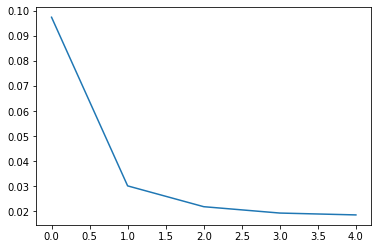

In [113]:
%matplotlib inline
#Model Training Visualization
import matplotlib.pyplot as plt
plt.plot(loss_graph)

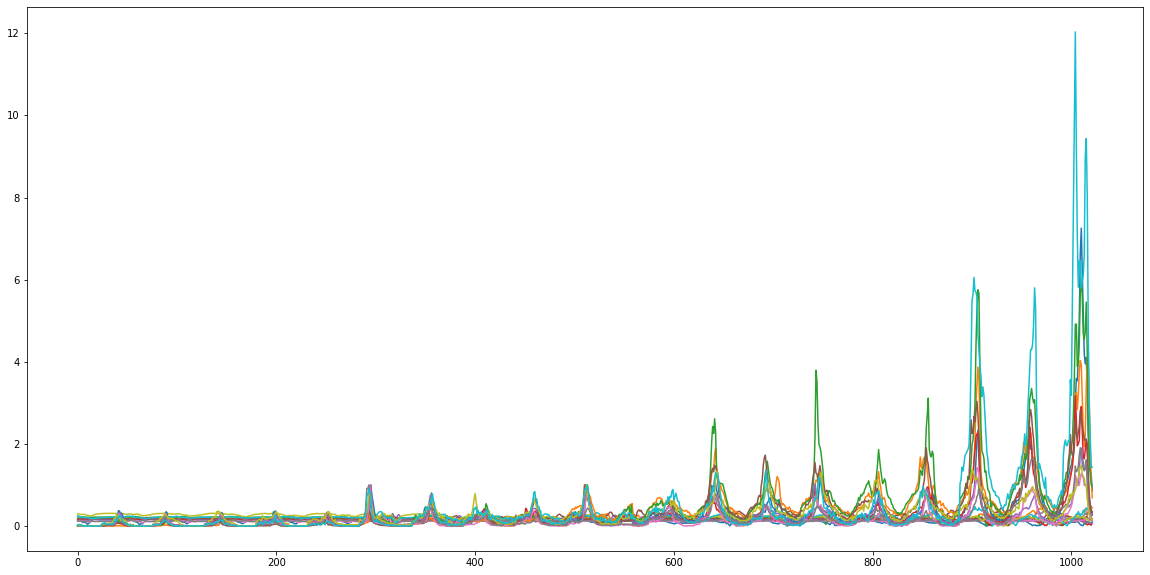

In [114]:
#Predicting for the test values

with torch.no_grad():
    predict_values = []
    actual_values = []
    
    for data in trainloader:
        seq, target = data
        out = model(seq)
        predict_values += [abs(out).cpu().numpy().tolist()]
        actual_values += target.cpu().numpy().tolist()
    
    for data in testloader:
        seq, target = data
        out = model(seq)
        predict_values += [abs(out).cpu().numpy().tolist()]
        actual_values += target.cpu().numpy().tolist()
        
plt.figure(figsize=(20,10))
plt.plot(predict_values)
plt.plot(actual_values)


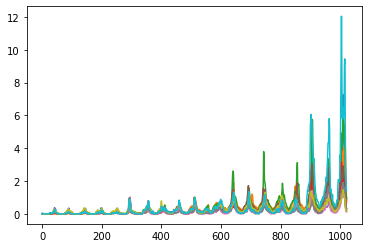

In [120]:
plt.plot(actual_values)

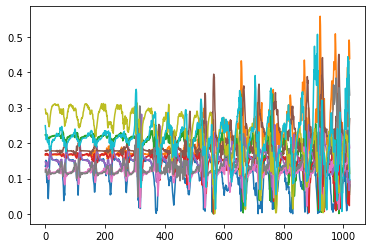

In [121]:
plt.plot(predict_values)

In [ ]:
len(actual_values), len(predict_values)

(1022, 1022)

actual_values

predict_values